In [12]:
import numpy as np
import pandas as pd
from sklearn import tree, metrics
import graphviz
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from itertools import product

sns.set(rc={"figure.figsize": (12, 9)})
sns.set_context("paper")
sns.set_style(style="white")

data_path = "/media/ilbumi/99a240cd-4c5b-45dd-8066-232540cb525e/united_data_lib/"

In [7]:
df = pd.read_csv(data_path + "cog/full_output_matrix.csv", index_col=0).T
filt = pd.read_csv(data_path + "cog/membr_part.csv", header=None)
df = df[filt[filt[1]>0.1][0]]
df = df.loc[:, df.mean() < .6]
cogs = df.columns
labels = pd.read_csv(data_path + "cog/bioenerg.csv", index_col=6)
df = df.join(labels)
df = df[df["Coupling ion"].isin(["Na+", "H+"])]  # dropping all species with more than one type of ATPases
df["Coupling ion"] = df["Coupling ion"]=="Na+"

# Testing filtering options

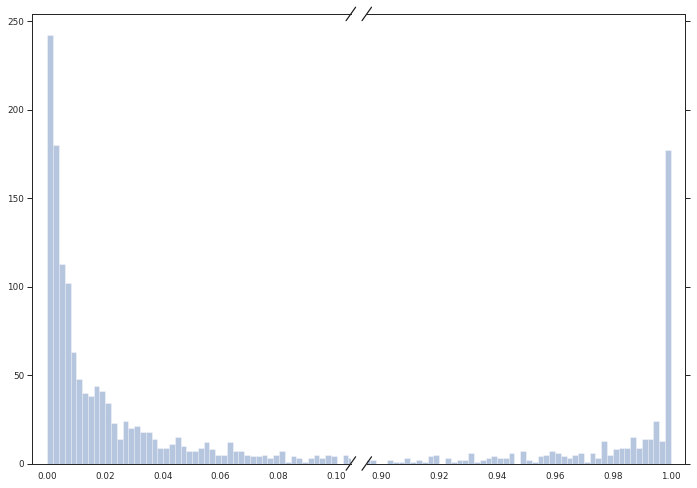

In [8]:
f, (ax, ax1) = plt.subplots(1, 2, sharey=True, figsize=(11.7, 8.27))
f.subplots_adjust(wspace=0.05)
ax.set_xlim(-0.005, 0.105)
ax1.set_xlim(0.895, 1.005)
sns.distplot(filt[1], ax=ax, kde=False, bins=500)
sns.distplot(filt[1], ax=ax1, kde=False, bins=500)

ax.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d,+d), (1-d,1+d), **kwargs)
ax1.plot((-d,+d), (-d,+d), **kwargs)
ax.set_xlabel("")
ax1.set_xlabel("")
plt.savefig("membr_part.png")
#df.mean()

# Decision tree approach
The tree can reveal COGs clusters.

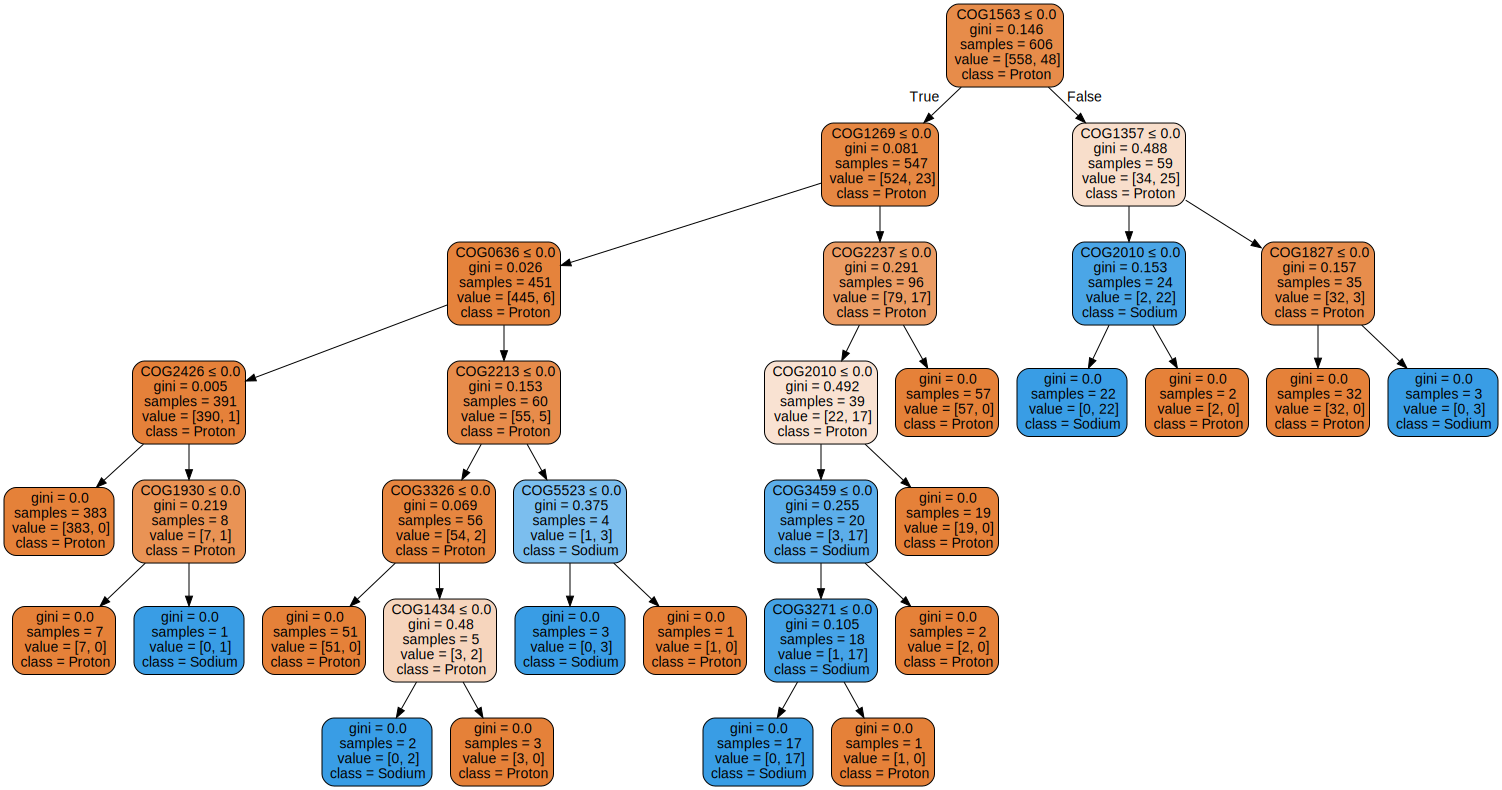

In [9]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df[cogs].astype(np.int)*2-1, df["Coupling ion"])
dot_data = tree.export_graphviz(clf, out_file=None, 
    feature_names=cogs,  
    class_names=["Proton", "Sodium"],  
    filled=True, rounded=True,  
    special_characters=True)  
graph = graphviz.Source(dot_data)
graph

Actually, there is no visible structure. It may be a sign of some noise in the data.  

# Correlation with the type of bioenergetics

In [13]:
info = {}
names = pd.read_csv(data_path + "cog/cognames2003-2014.tab", sep="\t", index_col=0)
for cog in cogs:
    info[cog] = [
        float(metrics.matthews_corrcoef(df[cog].values, df["Coupling ion"].values)),
        float(1-scipy.spatial.distance.dice(df[cog].values, df["Coupling ion"].values)),
        names.loc[cog]["name"]
    ]

In [14]:
infos = pd.DataFrame(info, index=["Pearson", "Dice",  "Name"]).T
infos = infos.dropna()
infos.sort_values("Dice", ascending=False).to_csv("cogs_correlation_weak_filter.csv")

dices = []
for v in np.random.choice([0, 1], p=[1-np.average(df[cogs]), np.average(df[cogs])], size=(10000, len(df))):
    dices.append(float(1-scipy.spatial.distance.dice(v, df["Coupling ion"].values)))
#sns.distplot(infos["Dice"])
[1-np.average(df[cogs]), np.average(df[cogs])]

[0.8025302530253026, 0.19746974697469746]

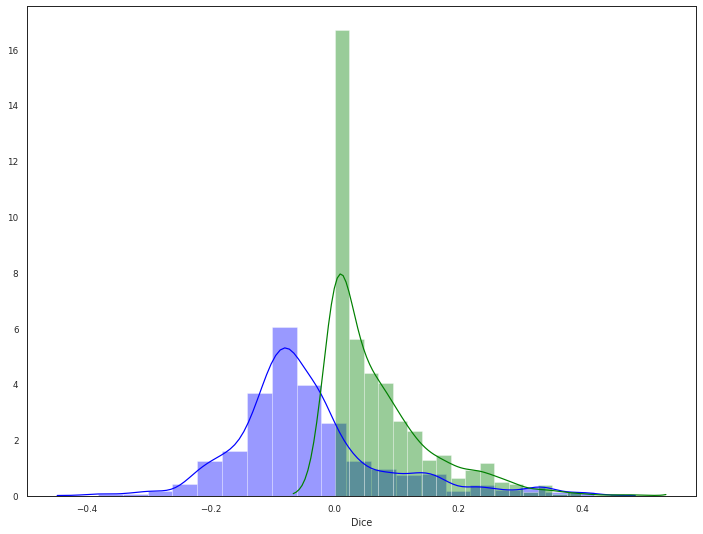

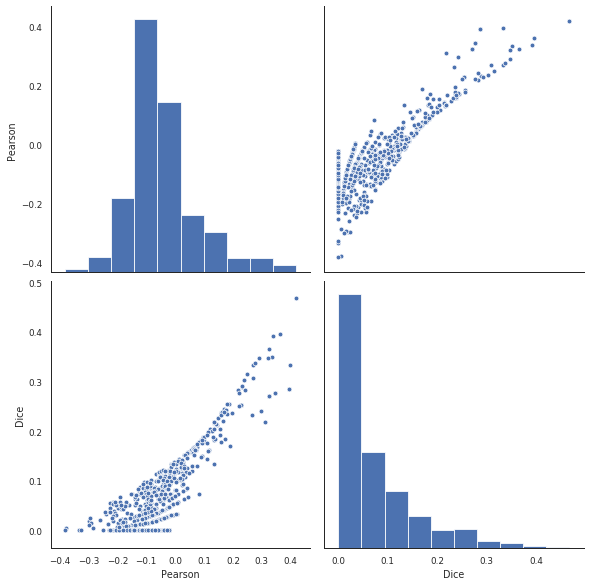

In [15]:
# coefficients distributions:

sns.distplot(infos["Pearson"].astype(float), bins=20, color="blue")
sns.distplot(infos["Dice"].astype(float), bins=20, color="green")
#sns.distplot(normalized_cq["info"].astype(np.float32), bins=20, color="red")
plt.show()
sns.pairplot(infos[["Pearson", "Dice"]].astype(np.float32), height=4)
plt.savefig("pear-dice.png")
#sns.scatterplot(x=infos["info"].astype(np.float32), y=infos["dice"].astype(np.float32))

In [16]:
suggested_sample = infos[infos["Dice"]>0.167]
anticorr_sample = infos[infos["Dice"]<0.167]
suggested_sample.sort_values("Dice", ascending=False)

,Pearson,Dice,Name
COG1563,0.41897,0.46729,Uncharacterized MnhB-related membrane protein
COG1269,0.362606,0.39521,Archaeal/vacuolar-type H+-ATPase subunit I/STV1
COG1827,0.338865,0.391753,"Transcriptional regulator of NAD metabolism, c..."
COG4945,0.326774,0.365854,Carbohydrate-binding DOMON domain
COG0636,0.335375,0.35023,"FoF1-type ATP synthase, membrane subunit c/Arc..."
...,...,...,...
COG4089,0.0936034,0.175439,Uncharacterized membrane protein
COG2059,0.0770572,0.174194,Chromate transport protein ChrA
COG4906,0.188971,0.169492,Uncharacterized membrane protein
COG1347,0.0768728,0.169014,Na+-transporting NADH:ubiquinone oxidoreductas...


# COG compexes. Barcoding. Results verification 

## Pairwise crosscorrelation. COGs clustering

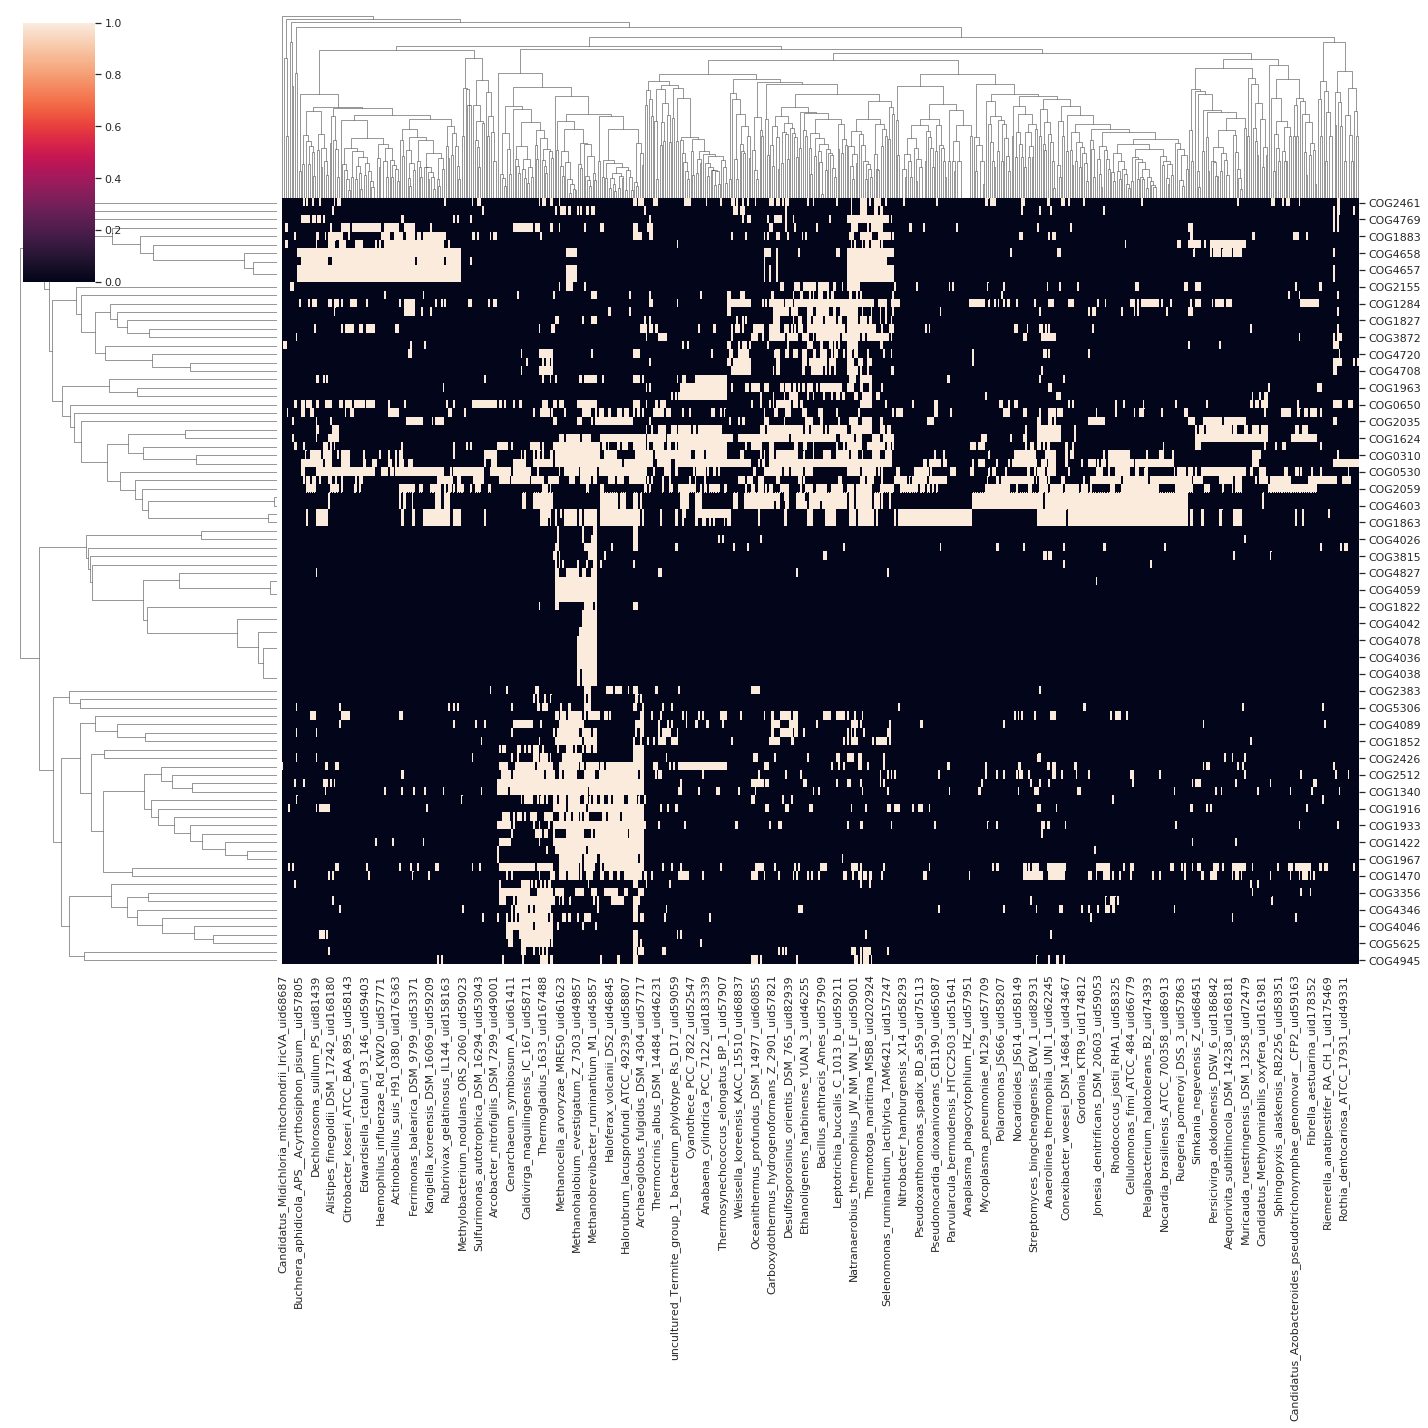

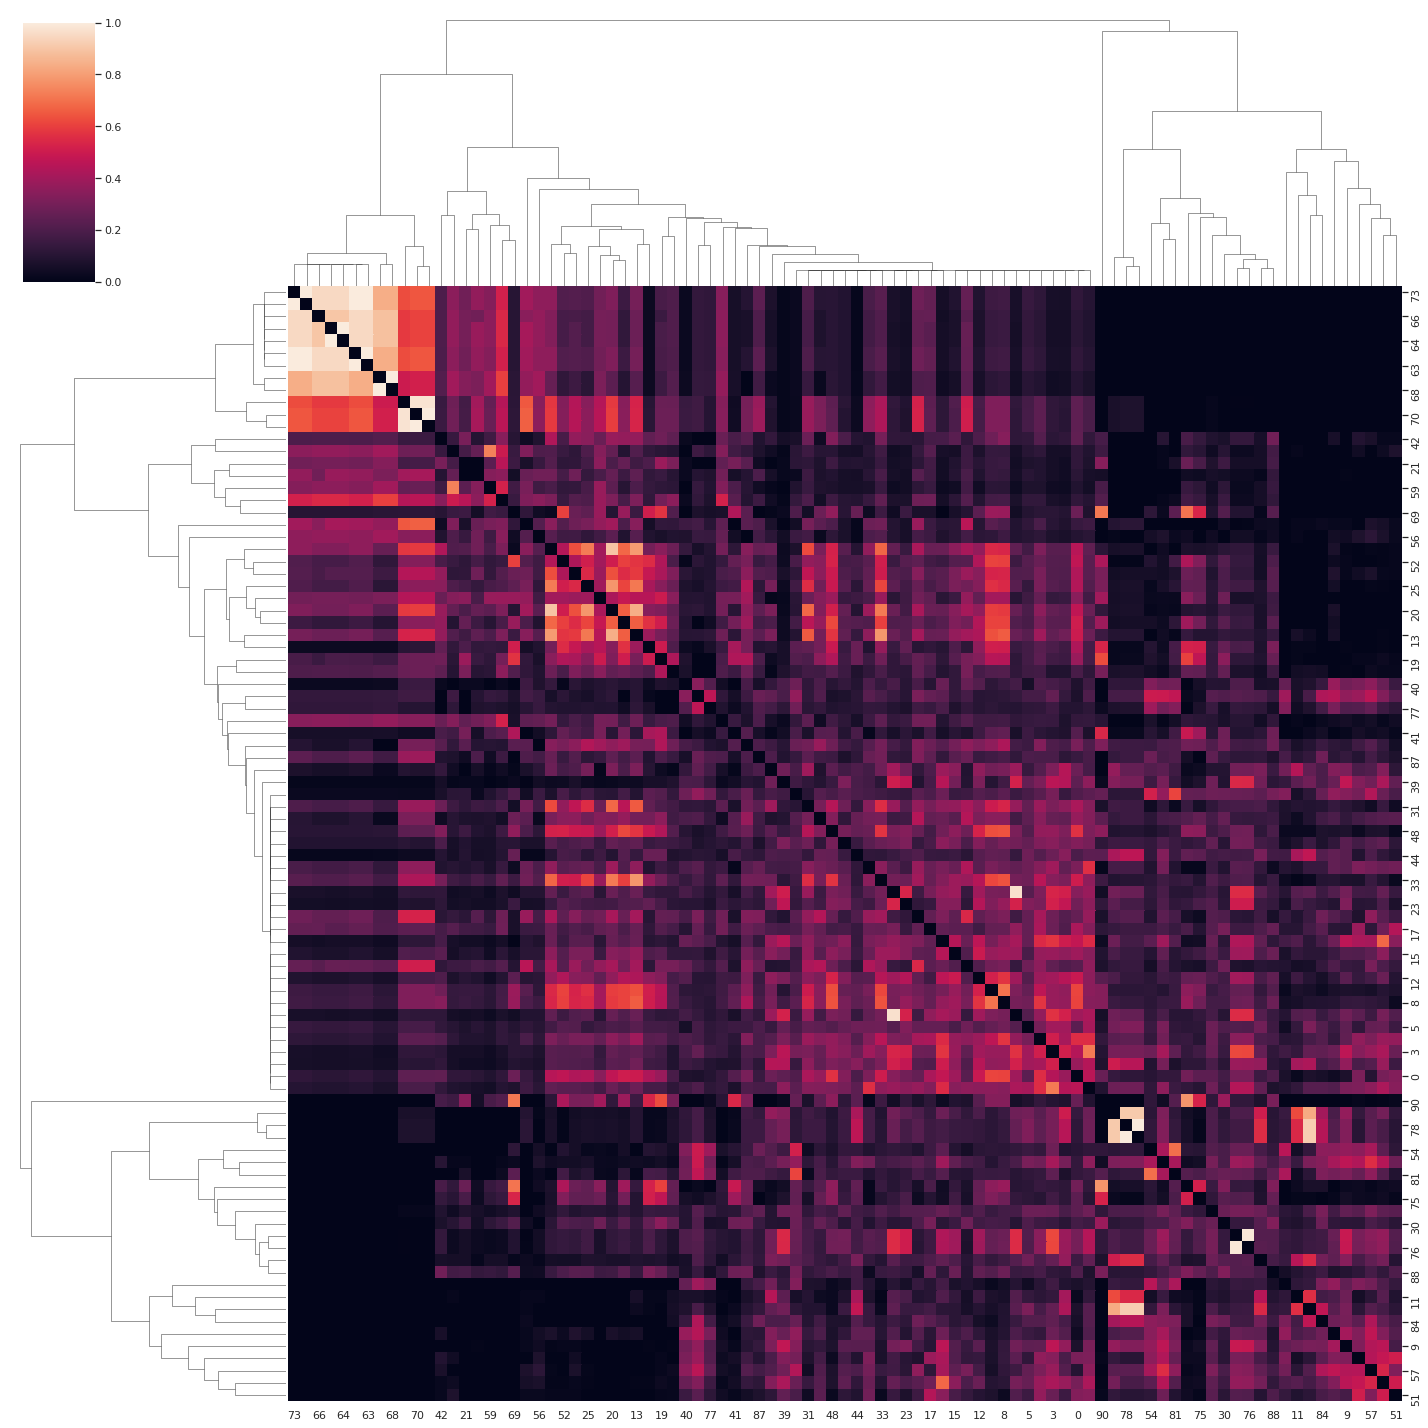

In [23]:
dft = df[np.array(suggested_sample.index)].T.copy()
dft = dft.loc[:, dft.sum()!=0]
sns.clustermap(
    dft, 
    metric="dice",
    figsize=(20, 20)
)
sns.clustermap(
    scipy.spatial.distance.squareform(1-scipy.spatial.distance.pdist(dft, "dice")), 
    metric="dice",
    figsize=(20, 20)
)

In [86]:
rel = []
for minimum in minimums:
    x, y = minimum[0][[0, 2]]
    rel.append(y/x)

/home/ilbumi/anaconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/home/ilbumi/anaconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [30]:
# Theoretical distributions of the correlations. We are trying to get empirical threshold for 0.05 significance level.

def dice(x):
    tt, tf, ft, ff = x
    return 2*tt/(2*tt+tf+ft)

def matthews(x):
    tt, tf, ft, ff = x
    return (tt*ff - tf*ft)/np.sqrt((tt+tf)*(tt+ft)*(ff+tf)*(ff+ft))


cons = (
        {'type': 'eq', 'fun': lambda x:  np.sum(x)-1},
        {'type': 'eq', 'fun': lambda x:  x[0]+x[1]-0.086},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: x[3]},
        {'type': 'ineq', 'fun': lambda x: 0.086-x[0]},
        {'type': 'ineq', 'fun': lambda x: 0.914-x[1]},
        {'type': 'ineq', 'fun': lambda x: 0.914-x[2]},
        {'type': 'ineq', 'fun': lambda x: 0.914-x[3]},
)
minimums = [[],[],[]]
for i in range(100):
    x1 = np.random.uniform(low=0.0, high=0.086)
    x2 = np.random.uniform(low=0.0, high=0.914)
    x3 = np.random.uniform(low=0.0, high=0.914)
    x4 = np.random.uniform(low=0.0, high=0.914)
    optd = scipy.optimize.minimize(
        lambda k: -dice(k),
        (x1, x2, x3, x4),
        constraints=cons
    )
    optm = scipy.optimize.minimize(
        lambda k: -matthews(k),
        (x1, x2, x3, x4),
        constraints=cons
    )
    opti = scipy.optimize.minimize(
        lambda k: -mutual_entropy_parametric(k),
        (x1, x2, x3, x4),
        constraints=cons
    )
    minimums[0].append((np.round(optd.x, 3), opt.fun))
    minimums[1].append((np.round(optm.x, 3), opt.fun))
    minimums[2].append((np.round(opti.x, 3), opt.fun))

In [54]:
np.quantile(dices, 0.95)

0.16568047337278102

In [51]:
a

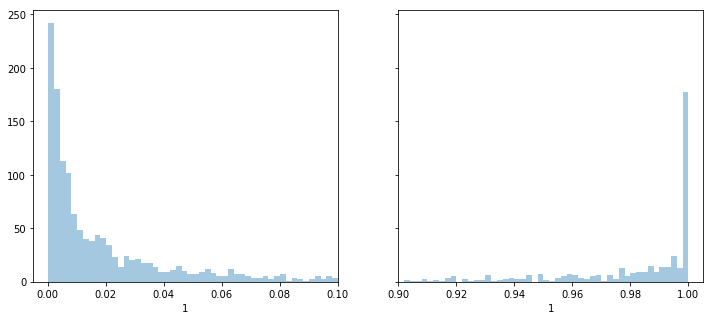

In [99]:
f = df.mean()<0.6
columns = list(f[f==True])

NormaltestResult(statistic=37.61169186506999, pvalue=6.803382428117505e-09)

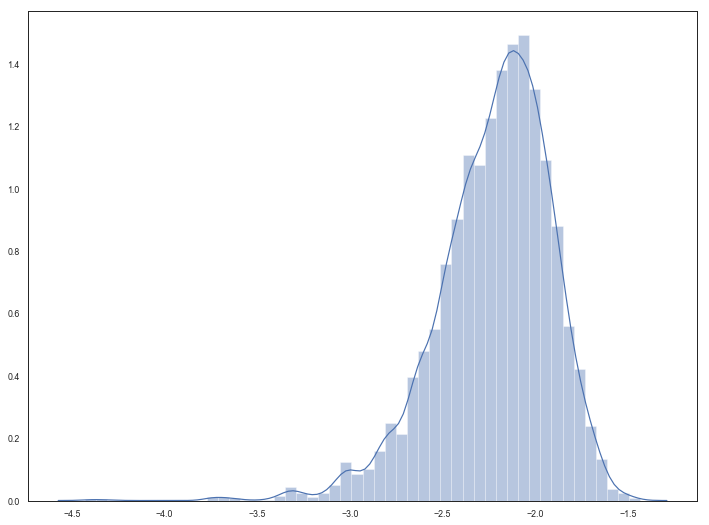

In [57]:
sns.distplot(np.log(np.array(dices)+0.00001))
scipy.stats.normaltest(np.log(np.array(dices)+0.00001))
scipy.stats.normaltest(dices)

In [30]:
rejected = labels.loc[set(labels.index) - set(df.index)].sort_values("Phylum")
len(rejected[~rejected["Phylum"].isin(["Bacteroidetes", "Chlamydiae", "Chlorobi", "Cyanobacteria", "Proteobacteria", "Spirochaetes", "Thermotogae"])])

47

In [16]:
labels.loc[set(labels.index) - set(df.index)].sort_values?

Object `sort_values` not found.


In [58]:
np.quantile(dices, 0.95)

0.16666666666666663

In [4]:
df["COG1883"]

Acetohalobium_arabaticum_DSM_5501_uid51423                          0.0
Achromobacter_xylosoxidans_A8_uid59899                              0.0
Acidianus_hospitalis_W1_uid66875                                    0.0
Acidilobus_saccharovorans_345_15_uid51395                           0.0
Acidimicrobidae_bacterium_YM16_304_uid193703                        0.0
Acidimicrobium_ferrooxidans_DSM_10331_uid59215                      0.0
Acidithiobacillus_ferrooxidans_ATCC_23270_uid57649                  0.0
Acidothermus_cellulolyticus_11B_uid58501                            0.0
Acidovorax_avenae_ATCC_19860_uid42497                               0.0
Acinetobacter_baumannii_ATCC_17978_uid58731                         0.0
Actinobacillus_suis_H91_0380_uid176363                              1.0
Actinoplanes_friuliensis_DSM_7358_uid226110                         0.0
Actinosynnema_mirum_DSM_43827_uid58951                              0.0
Advenella_kashmirensis_WT001_uid80859                           

In [48]:
anticorr_sample.sort_values("Dice", ascending=False)

,Pearson,Dice,Name
COG1270,-0.00267335,0.137203,Cobalamin biosynthesis protein CobD/CbiB
COG1175,-0.0104799,0.134367,"ABC-type sugar transport system, permease comp..."
COG1585,-0.00871556,0.133333,Membrane protein implicated in regulation of m...
COG0368,-0.0144036,0.132992,Cobalamin synthase
COG0555,-0.0225819,0.122186,"ABC-type sulfate transport system, permease co..."
COG1459,-0.0420482,0.121827,"Type II secretory pathway, component PulF"
COG2111,-0.0171267,0.11985,"Multisubunit Na+/H+ antiporter, MnhB subunit"
COG1172,-0.0212155,0.119718,Ribose/xylose/arabinose/galactoside ABC-type t...
COG1301,-0.0490711,0.119701,Na+/H+-dicarboxylate symporter
COG1277,-0.0543937,0.116751,ABC-type transport system involved in multi-co...


In [120]:
suggested_sample[["Name", "Dice"]].sort_values("Dice", ascending=False).to_csv("sc.csv")

# Visualization

In [23]:
import altair as alt


def custom_theme():
    markColor = "#4BAD53"
    axisColor = "#282828"
    backgroundColor = "#F3F3F3"
    font = "Lato"
    labelfont = "Lato"
    sourcefont = "Lato"
    gridColor = "#C9C9C9"
    return {
        "width": 685,
#        "height": 400,   
        "autosize": "fit",
        "config": {
           "padding": 10,
           "geoshape": {
               "fill": "#C0C0C0",
           },
           "arc": {
               "fill": markColor,
           },
           "area": {
               "fill": markColor,
           },
           "axisBand": {
               "grid": False,
           },
           "axisBottom": {
               "domain": False,
               "domainColor": "black",
               "domainWidth": 3,
               "grid": True,
               "gridColor": gridColor,
               "gridWidth": 1,
               "labelFontSize": 20,
               "labelFont": labelfont,
               "labelPadding": 8,
               "labelAngle": 0,
               "tickColor": axisColor,
               "tickSize": 10,
               "titleFontSize": 16,
               "titlePadding": 10,
               "titleFont": font,
               "title": "",
           },
           "axisLeft": {
               "domainColor": axisColor,
               "domainWidth": 1,
               "gridColor": gridColor,
               "gridWidth": 1,
               "labelFontSize": 20,
               "labelFont": labelfont,
               "labelPadding": 8,
               "tickColor": axisColor,
               "tickSize": 10,
               "tickCount": 10,
               "ticks": True,
               "titleFontSize": 18,
               "titlePadding": 10,
               "titleFont": font,
           },
           "axisRight": {
               "domainColor": axisColor,
               "domainWidth": 1,
               "gridColor": gridColor,
               "gridWidth": 1,
               "labelFontSize": 12,
               "labelFont": labelfont,
               "labelPadding": 4,
               "tickColor": axisColor,
               "tickSize": 10,
               "ticks": True,
               "titleFontSize": 14,
               "titlePadding": 10,
               "titleFont": font,
           },
           "axisTop": {
               "domain": False,
               "domainColor": "black",
               "domainWidth": 3,
               "grid": True,
               "gridColor": gridColor,
               "gridWidth": 1,
               "labelFontSize": 12,
               "labelFont": labelfont,
               "labelPadding": 4,
               "tickColor": axisColor,
               "tickSize": 10,
               "titleFontSize": 14,
               "titlePadding": 10,
               "titleFont": font,
           },
           "background": backgroundColor,
           "group": {
               "fill": backgroundColor,
           },
           "legend": {
               "labelFontSize": 30,
               "labelFont": labelfont,
               "labelLimit": 500,
               "padding": 10,
               "symbolSize": 500,
               "symbolType": "square",
               "titleFontSize": 30,
               "titlePadding": 10,
               "titleFont": font,
           },
           "line": {
               "color": markColor,
               "stroke": markColor,
               "strokewidth": 5,
           },
           "trail": {
               "color": markColor,
               "stroke": markColor,
               "strokeWidth": 0,
               "size": 5,
           },
           "path": {
               "stroke": markColor,
               "strokeWidth": 0.5,
           },
           "point": {
               "filled": True,
           },
           "rect": {
               "fill": "#A20C4B",
               "opacity": 0.3,
           },
           "range": {
               "category": ["#dc0d7a", "#02a3cd", "#e4a100", "#dc0d12", "#0DDC6F","#074a7e", "#e46800", "#aa3594", "#a20c4b"],
               "diverging": [
                   "#dc0d12",
                   "#e9686b",
                   "#fbe1e1",
                   "#dff4f9",
                   "#81d1e6",
                   "#03a3cd"
               ],
               "heatmap": [
                   "#fcdfef",
                   "#f8bfde",
                   "#f59fce",
                   "#f180be",
                   "#ee60ad",
                   "#eb409d",
                   "#e7208c",
                   "#e4007c",
               ],
           },
           "symbol": {
               "opacity": 1,
               "shape": "circle",
               "size": 40,
               "strokeWidth": 1,
           },
           "style": {
              "bar": {
                   "binSpacing": 2,
                   "fill": markColor,
                   "stroke": False,
               },
               "text": {
                   "font": sourcefont,
                   "fontSize": 10,
                   "align": "right",
                   "text": "Made by @ChekosWH",
                   "href": "https://twitter.com/ChekosWH",
                   "fontWeight": 100,
                   "size": 10,
                   "dx": 300,
               }
           },
           "title":{
               "anchor": "start",
               "fontSize": 12,
               "fontWeight": 200,
               "font": font,
               "offset": 20,
           },
           "view": {
               "stroke": False,
               "padding": 15,
           },
            "header": {
                "fontWeight": 400,
                "labelFontSize": 28,
                "labelFont": labelfont,
                "titleFontSize": 28,
                "titleFont": font,
                "title": " ",
                "titleBaseline": "bottom",
                "titleOffset": -30,
            },
       },
    }

alt.themes.register("my_custom_theme", custom_theme)
alt.themes.enable("my_custom_theme")
filt.columns = ["COG", "Membranous part"]

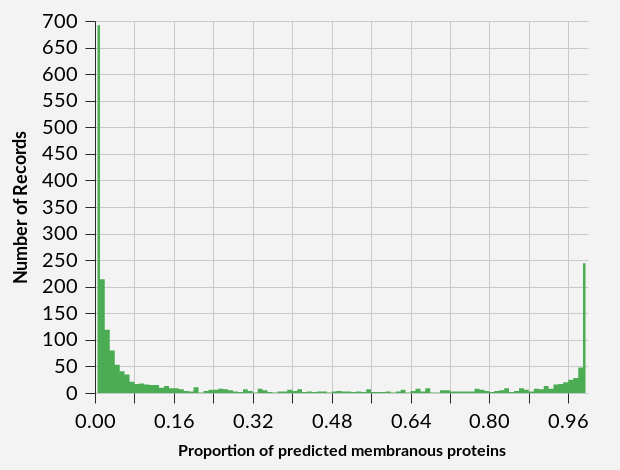

In [24]:
alt.Chart(filt, height=450, width=600).mark_area(interpolate="step").encode(
    alt.X('Membranous part', title="Proportion of predicted membranous proteins", bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None)
)

In [32]:
suggested_vectors = df[suggested_sample.index].T.values

# Dimensions reduction.
Is there some structure in the COGs occurance?

In [29]:
from sklearn import manifold as mf
from sklearn import manifold as mf
from scipy.spatial import distance as dist

In [53]:
emb = mf.TSNE(n_components=2, metric="dice", verbose=2)
#diss = dist.squareform(dist.pdist(suggested_vectors, "dice"))
emb.fit(suggested_vectors)

[t-SNE] Computing 90 nearest neighbors...
[t-SNE] Indexed 91 samples in 0.001s...
[t-SNE] Computed neighbors for 91 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 91 / 91
[t-SNE] Mean sigma: 0.323856


/home/ilbumi/anaconda3/envs/sci/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


[t-SNE] Computed conditional probabilities in 0.318s
[t-SNE] Iteration 50: error = 57.9005508, gradient norm = 0.4909680 (50 iterations in 0.132s)
[t-SNE] Iteration 100: error = 58.7731361, gradient norm = 0.4599478 (50 iterations in 0.019s)
[t-SNE] Iteration 150: error = 57.9475288, gradient norm = 0.5410572 (50 iterations in 0.016s)
[t-SNE] Iteration 200: error = 56.2554169, gradient norm = 0.5736839 (50 iterations in 0.017s)
[t-SNE] Iteration 250: error = 58.8905144, gradient norm = 0.4882295 (50 iterations in 0.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.890514
[t-SNE] Iteration 300: error = 1.1283463, gradient norm = 0.0069932 (50 iterations in 0.018s)
[t-SNE] Iteration 350: error = 1.2088366, gradient norm = 0.0098584 (50 iterations in 0.017s)
[t-SNE] Iteration 400: error = 0.9384072, gradient norm = 0.0025904 (50 iterations in 0.017s)
[t-SNE] Iteration 450: error = 0.6916061, gradient norm = 0.0017615 (50 iterations in 0.015s)
[t-SNE] Iteration 5

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='dice', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
   random_state=None, verbose=2)

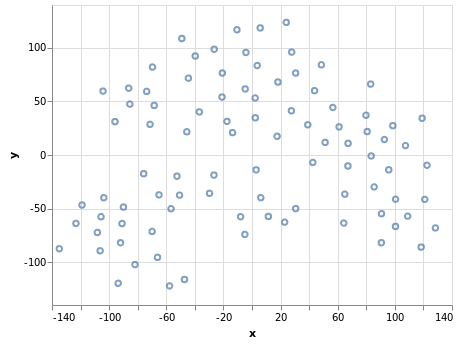

In [54]:
embedding = pd.DataFrame(emb.embedding_, columns=["x", "y"])

alt.Chart(embedding).mark_point().encode(
    x="x",
    y="y"
)

In [48]:
embedding["COG"] = suggested_sample.index

In [49]:
embedding

,x,y,COG
0,0.406355,0.171945,COG0170
1,0.072448,0.214155,COG0310
2,0.229513,0.293091,COG0530
3,-0.216909,-0.342200,COG0619
4,0.032556,-0.403902,COG0636
5,0.228019,0.003031,COG0650
6,-0.180192,-0.006321,COG1006
7,-0.192659,-0.308329,COG1079
8,0.236517,0.373218,COG1269
9,-0.339160,0.262686,COG1284
